## Background / Motivation

The crack of the bat and the baseball snapping in the leather of the glove are two of the most iconic sounds in sports, and have defined America's National Pastime for well over a century. Up until the turn of the millenium, unless there was a beat reporter in the press box hammering away on a typewriter, the mechanical sounds of a keyboard and mouse, and by extension, a computer, would be the furthest from the sound of baseball you could possibly get.

But, something changed. The increasing use of statistics by those involved in the game, a development portrayed in popular culture by the movie Moneyball, brought computers to the forefront due to their ability to process and interpret large quantities of data. Now, instead of relying on the naked eye, Major League Baseball (MLB) teams take advantage of fine-tuned formulas and high-speed cameras all around their ballparks to quantify player performance.

As a group, we were particularly fascinated by this "revolution" — which certainly isn't exclusive to baseball — and wanted to take a swing at some of the techniques those on the bleeding edge of sports analytics employ.

## Problem statement 

We want to predict how many home runs each player that had at least 200 plate apperances last year in Major League Baseball will hit in the 2023 season. We will develop a linear regression model focused on prediction to do this.

## Data sources
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

To complete this project, we will be using a fantastic site for baseball statistics called FanGraphs, which can be found at the below link:

[Fangraphs](https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2022&month=0&season1=2022&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=2022-01-01&enddate=2022-12-31)

We downloaded three datasets — Dashboard, Batted Ball and Statcast — from this page for each season all the way back to 2015, filtering before exporting by players who had at least 200 plate apperances. This minimum threshold was set to avoid any small sample variance with statistics, such as a player with one plate appearance that resulted in a home run, to avoid outliers down the road.

These datasets contain a variety of statistics, not all related to home run production, but together provide enough relevant features to provide good idea of the type of hitter each player is.

## Stakeholders

We identified four main stakeholders who this analysis benefits: MLB front offices, brands and agents, sportsbooks/bettors and fantasy baseball managers. 

All of these groups have something in common — knowing how players will do in the future gives them much greater chance of success. 

MLB executives who are in charge of building a winning roster will know which players to target to make their team better (granted home run numbers aren't the only thing that matters in this regard). This also applies to people who have a fantasy baseball team, as it arms them with more/better information when they're heading into their fantasy drafts, which should result in a better team.

Agents and sponsors can find potential new clients based on predicted breakouts. For example, say a player hit 10 home runs last year but our model expects him to hit 25 this time around, getting that player on a brand deal before they've seen greater success can be extremely lucrative.

Sportsbooks, who will have home run total prop bets, can set their Over/Unders more accurately, which in theory means they'll make more money. Same goes for gamblers looking at these lines, as they can make more informed decisions on what bets they should make.

## Data quality check / cleaning / preparation 

After reading in the .csv files from Fangraphs, there were quite a few steps that needed to be taken to create the train and test datasets:

1. Subsetted the three dataframes from each season for relevant variables, and then merge them together by `player_id`
2. Added a `Year` variable to tell apart players who have multiple observations, as they've played multiple seasons
3. Created the response variable, `Next_Year_HR`, using the dataset from the following season
4. Divided the yearly frames into 80% train and 20% test using a set random seed
5. Concatenated all of the train frames together and all of the test frames together to create the overall train and test datasets
6. Renamed columns with % and / symbols in them
7. Converted any rate variables to numeric, as they originally had % signs in the values, which had to be removed

One more note, to deal with the 2020 season which was shortened from 162 games down to 60 as a result of the pandemic, all counting stats, like plate appearances, games played, etc., were scaled up by a factor of 162/60.

In [20]:
import pandas as pd
train = pd.read_csv(r'.\Datasets\train.csv')
test = pd.read_csv(r'.\Datasets\test.csv')

In [21]:
train.iloc[:, 1:12].describe()

,G,PA,HR,BB,K,playerid,LD,GB,FB,IFFB,HRperFB
count,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000
mean,123.577049,479.768525,16.682623,8.766230,21.028656,10708.931803,21.269180,42.998230,35.733377,9.245049,13.998885
std,28.389748,143.388674,10.393075,3.286636,6.047531,4949.608521,3.279545,6.904258,6.898324,4.614579,6.944120
min,46.000000,189.000000,0.000000,1.500000,5.300000,393.000000,10.300000,21.100000,11.300000,0.000000,0.000000
25%,103.000000,367.000000,9.000000,6.400000,16.700000,6368.000000,19.100000,38.200000,30.800000,6.100000,9.300000
50%,129.000000,491.000000,15.000000,8.500000,20.900000,11038.000000,21.100000,42.900000,36.000000,9.000000,13.500000
75%,148.000000,604.000000,23.000000,10.700000,24.900000,14162.000000,23.400000,47.800000,40.600000,12.000000,18.300000
max,164.000000,747.000000,59.000000,23.200000,44.000000,26197.000000,35.700000,67.400000,60.500000,28.000000,46.700000


In [22]:
train.iloc[:, 12:].describe()

,Pull,Cent,Oppo,EV,maxEV,LA,Barrel,HardHit,Year,Next_Year_HR
count,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000
mean,40.504459,34.593639,24.904984,88.652721,110.459803,12.411672,6.920328,36.807148,2017.994098,16.565246
std,5.898777,3.650329,4.321715,2.233904,3.266471,4.560382,4.172135,8.036217,1.995886,10.640103
min,18.800000,21.800000,13.000000,80.500000,99.800000,-7.900000,0.000000,8.500000,2015.000000,0.000000
25%,36.800000,32.200000,21.900000,87.200000,108.300000,9.400000,3.700000,31.900000,2016.000000,8.000000
50%,40.400000,34.600000,24.700000,88.700000,110.300000,12.400000,6.400000,37.400000,2018.000000,14.000000
75%,44.300000,36.900000,27.700000,90.100000,112.700000,15.500000,9.500000,42.200000,2020.000000,23.000000
max,60.300000,50.000000,43.400000,96.000000,122.200000,27.000000,25.600000,62.200000,2021.000000,62.000000


In [23]:
test.iloc[:, 1:12].describe()

,G,PA,HR,BB,K,playerid,LD,GB,FB,IFFB,HRperFB
count,366.000000,366.00000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,123.543716,478.34153,17.683060,8.820765,21.877869,10994.234973,21.168579,42.774317,36.055738,9.451366,14.876776
std,29.177717,149.15784,10.879821,3.330828,6.151305,5129.126851,3.416081,6.707052,6.671223,4.443951,6.850548
min,45.000000,189.00000,0.000000,2.000000,7.400000,785.000000,13.300000,23.700000,18.200000,0.000000,0.000000
25%,102.000000,345.00000,9.000000,6.500000,17.100000,6427.000000,18.925000,38.000000,31.800000,6.300000,10.225000
50%,130.000000,499.00000,15.500000,8.400000,22.200000,11483.000000,20.900000,42.550000,35.550000,9.100000,14.350000
75%,148.000000,606.00000,25.000000,10.675000,26.175000,14731.500000,23.300000,47.500000,40.700000,12.100000,18.775000
max,162.000000,735.00000,59.000000,20.900000,45.700000,27506.000000,38.700000,60.800000,53.500000,25.000000,41.000000


In [24]:
test.iloc[:, 12:].describe()

,Pull,Cent,Oppo,EV,maxEV,LA,Barrel,HardHit,Year,Next_Year_HR
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,40.816940,34.679508,24.503552,88.931694,110.963115,12.593989,7.377869,37.843443,2018.060109,16.054645
std,5.929516,3.607138,4.276109,2.174770,3.262091,4.453974,3.993512,7.646140,1.997723,9.985045
min,21.600000,24.100000,11.000000,82.200000,101.400000,1.800000,0.000000,13.000000,2015.000000,0.000000
25%,36.800000,32.400000,21.700000,87.400000,108.800000,9.600000,4.725000,32.925000,2016.000000,8.250000
50%,40.750000,34.700000,24.300000,89.000000,110.800000,12.550000,6.950000,37.950000,2018.000000,14.000000
75%,44.700000,36.900000,27.400000,90.300000,113.300000,15.500000,9.600000,43.075000,2020.000000,23.000000
max,61.100000,44.800000,38.300000,96.100000,122.200000,24.800000,23.500000,55.900000,2021.000000,48.000000


## Exploratory data analysis

In [25]:
train.corrwith(train['Next_Year_HR']).sort_values(ascending = False)

Next_Year_HR    1.000000
HR              0.580841
Barrel          0.510056
EV              0.484289
HardHit         0.475586
maxEV           0.469366
HRperFB         0.456887
FB              0.355472
PA              0.331875
LA              0.286869
Pull            0.284040
G               0.248870
BB              0.186282
K               0.162704
IFFB            0.055192
playerid        0.036181
Year           -0.047982
LD             -0.130726
Cent           -0.167033
Oppo           -0.246531
GB             -0.292824
dtype: float64

We first looked at the correlations between all of our predictors and the response, and determined which variables had the strongest associations with the reponse.

From there, we created scatterplots of the relationships between the six most correlated predictors — `HR`, `Barrel`, `EV`, `HardHit`, `maxEV` and `HRperFB` — and the response to determine whether any transformations would be necessary in the initial model. It turned out that all of the relationships were linear, except for `HardHit`, which looked slightly quadratic, as shown in the below figure.

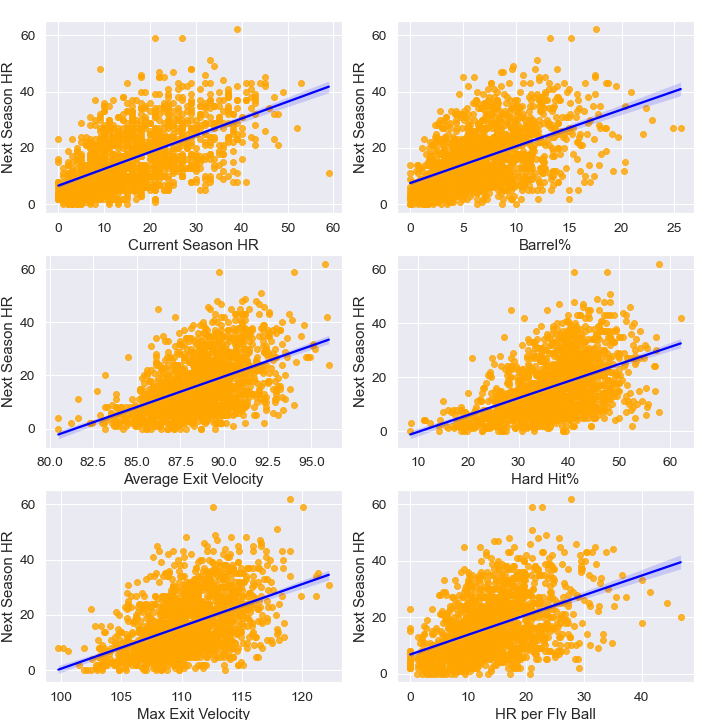

## Approach

We used a multiple linear regression model, and optimized it to get the lowest test RMSE.

The very first model had an influential point as well as a linear model assumption model violation, both of which we found when we created a residual plot. We then removed the influential point for the second iteration of the model, and took note of the violation for future models.

## Developing the model

After doing the EDA, we started with a base model that included just the six most correlated predictors plus a quadratic transformation of `HardHit`. This model yielded a train RSE of 8.29 home runs and a test RMSE of 8.18 home runs.

We then checked for any linear model assumption violations by plotting the residuals against the fitted values. While the linearity of the data assumption was satisfied, the residual plot showed a clear violation of the constant variance of error terms assumption, as the residuals increase in magnitude as the fitted value increases, as shown below.

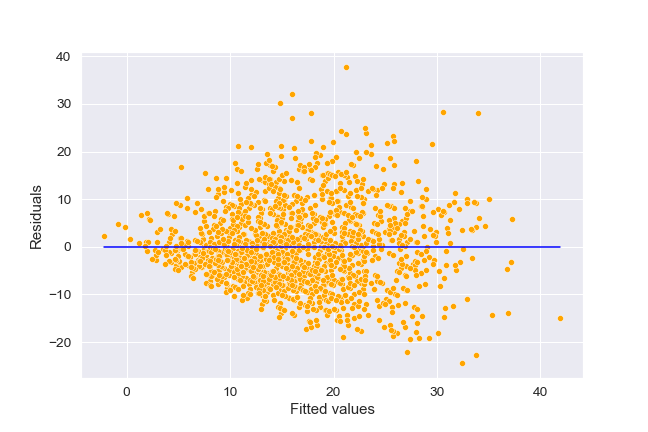

Next, we looked for any influential points, and found there was just one, so after removing that observation from the train dataset and refitting the model, the train RSE dropped to 8.26 and the test RMSE went down to 8.17.

Since we’re only focused on prediction, we did not worry about collinearity and VIF values, and there wasn’t any correlation between residuals, so the last two assumptions were fine.

Armed with the information from the EDA and the initial model, plus our experience with baseball, we set about creating a new model that gave us the lowest possible test RMSE.

First, to ensure the constant variance of error terms assumption wasn’t violated, we added a square root transformation of the response. As shown by the residual plot below, this was effective.

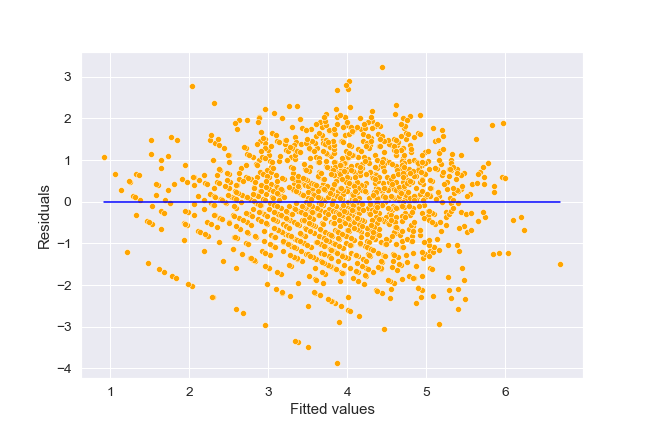

Now, to explain some of the interactions, transformations and inclusions of new predictors. 

Most of them are a result of trial and error with the test RMSE, but some of them were added from a pure data engineering perspective. For example, the `EV*maxEV` interaction makes perfectly good sense considering the average exit velocity off of one hitter’s bat is going to be influenced by their maximum exit velocity, and vice versa. Then, the other two interactions, `HRperFB*FB` and `IFFB*FB` add some context to a hitter’s overall fly ball rate. Two hitters could have the same overall home runs per fly ball percentage, but if one hits fly balls twice as often, that matters in predicting how many home runs each will end up with. Or, if two hitters hit fly balls the same percentage of the time, but one hits infield flies, which will never be home runs, twice as often, that too matters in projecting a total number of home runs.

In the end, we came up with a model with an 8.19 train RSE and an 8.04 test RMSE, and it didn’t violate any of the linear model assumptions nor have any influential points.

Lastly, just for the sake of touching all possible bases (no pun intended), we tried Lasso regression with all of the predictors. After standardizing the data, we found the optimal lambda value to be 0.05, and this model gave a train RSE of 8.14 and test RMSE of 8.14.

Since the test RMSE of our “engineered” model was lower than the Lasso model, we decided to go with the “engineered” model for making our predictions for the 2023 season.

### The final model equation

$\sqrt{{NextYearHR}} = 85.9873 + 0.0171 \cdot {HR} + 0.0208 \cdot {Barrel} - 1.0637 \cdot {EV} - 0.8581 \cdot {maxEV} + 0.0104 \cdot ({EV} \cdot {maxEV}) + 0.131 \cdot {HardHit} - 0.0016 \cdot {HardHit}^2 + 0.0599 \cdot {HRperFB} + 0.0406 \cdot {FB} - 0.0015 \cdot ({HRperFB} \cdot {FB}) + 0.0343 \cdot {IFFB} - 0.0007 \cdot ({IFFB} \cdot {FB}) + 0.0163 \cdot {Pull} + 0.0014 \cdot {PA} - 0.0098 \cdot {BB} - 0.0091 \cdot {K} - 0.0151 \cdot {GB}$

## Limitations of the model with regard to inference / prediction

The biggest limitation of the model is due to the unpredictability of sports. As we found while developing the model, players who hit a lot of home runs tend to have their totals vary vastly from year to year. Additionally, the model can't tell if a player will get injured, or if someone will have a vastly different role on their team than they did the prior season, both of which impact their opportunities to hit home runs.

Additionally, this model will become less and less useful in the coming months, as the MLB regular season starts on March 30, 2023, and since it only takes into account data from the prior season, a better model which also utilizes the current season's data could be trained.

In short, the window of opportunity for the model to have a purpose is the widest it's going to be at present, so our stakeholders should act quickly on our results.

## Conclusions and Recommendations to stakeholder(s)

What conclusions do you draw based on your model? If it is inference you may draw conclusions based on the coefficients, statistical significance of predictors / interactions, etc. If it is prediction, you may draw conclusions based on prediction accuracy, or other performance metrics.

How do you use those conclusions to come up with meaningful recommendations for stakeholders? The recommendations must be action-items for stakeholders that they can directly implement without any further analysis. Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

If your recommendations are not practically implementable by stakeholders, how will they help them? Is there some additional data / analysis / domain expertise you need to do to make the recommendations implementable? 

Do the stakeholder(s) need to be aware about some limitations of your model? Is your model only good for one-time use, or is it possible to update your model at a certain frequency (based on recent data) to keep using it in the future? If it can be used in the future, then for how far into the future?

In [38]:
predictions = pd.read_csv(r'.\Datasets\predictions_2023.csv')
predictions.loc[:, ['Name', 'Predicted_HR_2023_Integers']].sort_values(by = 'Predicted_HR_2023_Integers', ascending = False).head(10)

,Name,Predicted_HR_2023_Integers
353,Aaron Judge,42
233,Giancarlo Stanton,33
265,Shohei Ohtani,33
283,Matt Olson,32
350,Kyle Schwarber,32
266,Vladimir Guerrero Jr.,31
313,Yordan Alvarez,31
321,Austin Riley,31
340,Pete Alonso,30
317,Rowdy Tellez,29


Our model's projections for Top 10 home run hitters this upcoming season is shown above. If our stakeholders are looking for a big name power hitter, these are the players they should be prioritizing.

Additionally, using these predictions, we identified the 10 players expected to have the biggest jumps in home run production from last season to this one, as shown below.

In [33]:
predictions.loc[:, ['Name', 'Difference_in_HR', 'Predicted_HR_2023_Integers']].sort_values(by = 'Difference_in_HR', ascending = False).head(10)

,Name,Difference_in_HR,Predicted_HR_2023_Integers
6,Sam Hilliard,12,14
88,Oneil Cruz,11,28
26,Enrique Hernandez,9,15
41,Franchy Cordero,9,17
78,Jorge Soler,9,22
8,Seby Zavala,9,11
20,J.J. Bleday,9,14
24,Kyle Isbel,8,13
17,Austin Nola,8,12
85,Ketel Marte,8,20


These are names that should be looked at as potential high upside trade options for general managers, late round picks for fantasy managers in their drafts or good value bets, depending on the line, for gamblers. Also, we recommend that teams who currently have one or more of these players in their organziation to give them more opportunities, and potentially offer them new contracts now while they won't be as expensive. Although, if agents also have access to this information, they should advise their clients to not take those offers as they'll get more money after the season due to their performance.

Lastly, as mentioned in the previous section, this model will start becoming obsolete once we get to Opening Day of the 2023 season, so our stakeholders should on our findings now, or else they'll miss the opportunity to do so.

## GitHub and individual contribution {-}

[GitHub Repo](https://github.com/jcolsen44/STAT-303-2-Project)

<html>
<style>
table, td, th {
  border: 1px solid black;
}

table {
  border-collapse: collapse;
  width: 100%;
}

th {
  text-align: left;
}
    

</style>
<body>

<h2>Individual contribution</h2>

<table style="width:100%">
     <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 20%;">
       <col span="1" style="width: 50%;">
       <col span="1" style="width: 15%;"> 
    </colgroup>
  <tr>
    <th>Team member</th>
    <th>Contributed aspects</th>
    <th>Details</th>
    <th>Number of GitHub commits</th>
  </tr>
  <tr>
    <td>Melody Macharia</td>
    <td>Developing initial model</td>
    <td>Developed model based on EDA, examined any potential issues for follow-up model.</td>
    <td>20</td>
  </tr>
  <tr>
    <td>John Olsen</td>
    <td>Data cleaning, follow-up model, lasso regression</td>
    <td>Transformed Fangraphs datasets into train and test datsets, helped work on second model, tested lasso regression.</td>
    <td>18</td>
  </tr>
    <tr>
    <td>Kiran Sheth</td>
    <td>EDA, follow-up model</td>
    <td>Identified potentially significant predictors, worked on second model.</td>
    <td>N/A (see below)</td>    
  </tr>
    <tr>
    <td>Janya Sundar</td>
    <td>Data cleaning, EDA</td>
    <td>Checked train and test sets for any potential issues, produced scatterplots between predictors and response.</td>
    <td>6</td>    
  </tr>
</table>

Kiran Sheth: For me, I encountered several problems when collaborating with the team on GitHub. From the beginning, I was unable to commit or push any of the code into GitHub. After multiple attempts, talking to the professor and the TAs, I was unable to do so, which made collaboration much harder with the team. In the end, I was still able to contribute to the group, but this issue made it a lot harder for me to rely on GitHub for collaboration.

As a team, figuring out how to use GitHub was more of a hindrance than help, and while we see the value in it for collaboration and tracking contributions in any future projects or assignments, this time around was rough.